In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [ ]:
df_hongos = pd.read_csv("/content/drive/MyDrive/datosTP2/files/MushroomDataset/secondary_data.csv", delimiter=";")

In [ ]:
df_hongos

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,p,15.26,x,g,o,f,e,NaN,w,16.95,...,s,y,w,u,w,t,g,NaN,d,w
1,p,16.60,x,g,o,f,e,NaN,w,17.99,...,s,y,w,u,w,t,g,NaN,d,u
2,p,14.07,x,g,o,f,e,NaN,w,17.80,...,s,y,w,u,w,t,g,NaN,d,w
3,p,14.17,f,h,e,f,e,NaN,w,15.77,...,s,y,w,u,w,t,p,NaN,d,w
4,p,14.64,x,h,o,f,e,NaN,w,16.53,...,s,y,w,u,w,t,p,NaN,d,w
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61064,p,1.18,s,s,y,f,f,f,f,3.93,...,NaN,NaN,y,NaN,NaN,f,f,NaN,d,a
61065,p,1.27,f,s,y,f,f,f,f,3.18,...,NaN,NaN,y,NaN,NaN,f,f,NaN,d,a
61066,p,1.27,s,s,y,f,f,f,f,3.86,...,NaN,NaN,y,NaN,NaN,f,f,NaN,d,u
61067,p,1.24,f,s,y,f,f,f,f,3.56,...,NaN,NaN,y,NaN,NaN,f,f,NaN,d,u


Me quedo con 80% de los datos para train, 10% para validation y 10% para test. \\
Los separo al azar para obtener datos que representen bien todo el conjunto.

In [ ]:
y = df_hongos["class"]
X = df_hongos.drop("class", axis = 1)
tamanio_test = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=tamanio_test, random_state=9)

In [ ]:
tamanio_validation = 0.1 / (1 - tamanio_test)

In [ ]:
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=tamanio_validation, random_state=9)

##**Imputación de nulos:**

Imputo nulos sencillamente con los criterios siguientes. \\
(En los restantes dos modelos (RF, XGBoost) uso una imputación de nulos un poco más exhaustiva, pero como este es un baseline lo hago así sencillo).

Supongo que los NaN de "veil-type" son el otro valor posible ("p").

In [ ]:
X_train["veil-type"] = X_train["veil-type"].fillna("p")
X_validation["veil-type"] = X_validation["veil-type"].fillna("p")
X_test["veil-type"] = X_test["veil-type"].fillna("p")

Remplazo todos los NaN por *. Esto porque de forma sencilla no encontré nada para suponer otra cosa. \\
Uso * porque supongo que no lo van a pasar nunca como dato de una columna.



In [ ]:
X_train = X_train.fillna("*")
X_validation = X_validation.fillna("*")
X_test = X_test.fillna("*")

##**Encoding**:

Encodeo las columnas con variables categóricas solamente, y droppeo las columnas que sean la negación de otra, o sea, columnas con solo dos valores posibles, sabiendo que las columnas con solo dos variables ninguna contiene el "*" introducido.

In [ ]:
columnas_categoricas = df_hongos.select_dtypes(include=["object"]).columns.drop("class")

In [ ]:
one_hot_encoder_X = OneHotEncoder(sparse_output=False, drop="if_binary", dtype=int)

X_train_encoded = one_hot_encoder_X.fit_transform( X_train[columnas_categoricas] )
X_validation_encoded = one_hot_encoder_X.transform( X_validation[columnas_categoricas] )
X_test_encoded = one_hot_encoder_X.transform( X_test[columnas_categoricas] )

Los dejo con el índice original a cada set solo para que al final las predicciones se guarden respetando el índice del secondary_data.

In [ ]:
nombres_features = one_hot_encoder_X.get_feature_names_out(columnas_categoricas)

columnas_numericas = X_train[["cap-diameter", "stem-height", "stem-width"]]
X_train_encoded = pd.DataFrame(X_train_encoded, index=X_train.index, columns=nombres_features)
X_train_encoded = pd.concat([X_train_encoded, columnas_numericas], axis=1)

columnas_numericas = X_validation[["cap-diameter", "stem-height", "stem-width"]]
X_validation_encoded = pd.DataFrame(X_validation_encoded, index=X_validation.index, columns=nombres_features)
X_validation_encoded = pd.concat([X_validation_encoded, columnas_numericas], axis=1)

columnas_numericas = X_test[["cap-diameter", "stem-height", "stem-width"]]
X_test_encoded = pd.DataFrame(X_test_encoded, index=X_test.index, columns=nombres_features)
X_test_encoded = pd.concat([X_test_encoded, columnas_numericas], axis=1)

In [ ]:
y_train_encoded = y_train.map(lambda x: 0 if x == 'e' else 1)
y_validation_encoded = y_validation.map(lambda x: 0 if x == 'e' else 1)
y_test_encoded = y_test.map(lambda x: 0 if x == 'e' else 1)

##**Búsqueda hiperpaŕametros:**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

In [ ]:
log_reg = LogisticRegression(max_iter=100, random_state=9)

Busco los mejores hiperparámetros para la Logistic Regression, voy obteniendo los mejores parámetros y midiendo contra validation. Así iterativamente hasta llegar a los mejores.

In [ ]:
params = [
  #{
  #  'solver': ['lbfgs'],
  #  'penalty': [None, 'l2'],
  #  'C': [1, 10, 100]
  #}, 

  {
    'solver': ['liblinear'],
    'penalty': ['l1', 'l2'],
    'C': [4645, 4650, 4655]
  }
]

In [ ]:
randomized_search = RandomizedSearchCV(log_reg, param_distributions=params, n_iter=5, random_state=9, scoring='roc_auc')

In [ ]:
randomized_search.fit(X_train_encoded, y_train_encoded)

RandomizedSearchCV(estimator=LogisticRegression(random_state=9), n_iter=5,
                   param_distributions=[{'C': [4645, 4650, 4655],
                                         'penalty': ['l1', 'l2'],
                                         'solver': ['liblinear']}],
                   random_state=9, scoring='roc_auc')

In [ ]:
randomized_search.best_params_

{'solver': 'liblinear', 'penalty': 'l2', 'C': 4650}

In [ ]:
log_reg_model = randomized_search.best_estimator_

Entreno con el modelo con los mejores hiperparámetros encontrados.

In [ ]:
log_reg_model.fit(X_train_encoded, y_train_encoded)

LogisticRegression(C=4650, random_state=9, solver='liblinear')

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
roc_auc_score(y_train_encoded, log_reg_model.predict_proba(X_train_encoded)[:, 1])

0.9384528996677838

Voy midiendo contra validation para ver que combinación de hiperparámetros da mejor resultado.

In [ ]:
roc_auc_score(y_validation_encoded, log_reg_model.predict_proba(X_validation_encoded)[:, 1])

0.9407794696990379

**¿Cuál es el mejor score de validación obtenido? (¿Cómo conviene obtener el dataset para validar?)** \\
El mejor score de validación obtenido es el de arriba. \\
El set para validar conviene obtenerlo como un porcentaje del set original, no muy grande (10%, 15% por ejemplo). En este caso me pareció conveniente obtenerlo con un split aleatorio del dataset original, para poder validarlo al modelo con valores representativos de todo el dataset.

##**Predicción modelo final:**

**Al predecir con este modelo para test, ¿Cúal es el score obtenido? (guardar el csv con predicciones para entregarlo después)**

Una vez llegado al modelo final, mido contra test:

In [ ]:
roc_auc_score(y_test_encoded, log_reg_model.predict_proba(X_test_encoded)[:, 1])

0.9377005552526668

Me guardo las predicciones:

In [ ]:
predicciones = log_reg_model.predict(X_test_encoded)
predicciones = pd.DataFrame(predicciones, index=X_test_encoded.index, columns=["e"])
path = '/content/drive/MyDrive/datosTP2/files/MushroomDataset/predicciones_logreg.csv'
predicciones.to_csv(path)

https://drive.google.com/file/d/1-0Qgd117uDsZRSjWwPatz1Vw7-ZRvk2x/view?usp=sharing

##**Gráficos features:**

**¿Qué features son los más importantes para predecir con el mejor modelo? Graficar.**

Busco las features más importantes

In [ ]:
importancias_features = abs(log_reg_model.coef_).flatten()

In [ ]:
features_con_importancias = {}

for i, columna in enumerate(X_train_encoded.columns):
  features_con_importancias[columna] = importancias_features[i]

In [ ]:
df_features_por_importancia = pd.DataFrame( index=features_con_importancias.keys(), columns=["importancia_feature"], data=features_con_importancias.values())

In [ ]:
df_features_por_importancia = df_features_por_importancia.sort_values(by="importancia_feature", ascending=True)

Text(0.5, 1.0, 'Top 15 features específicas más importantes')

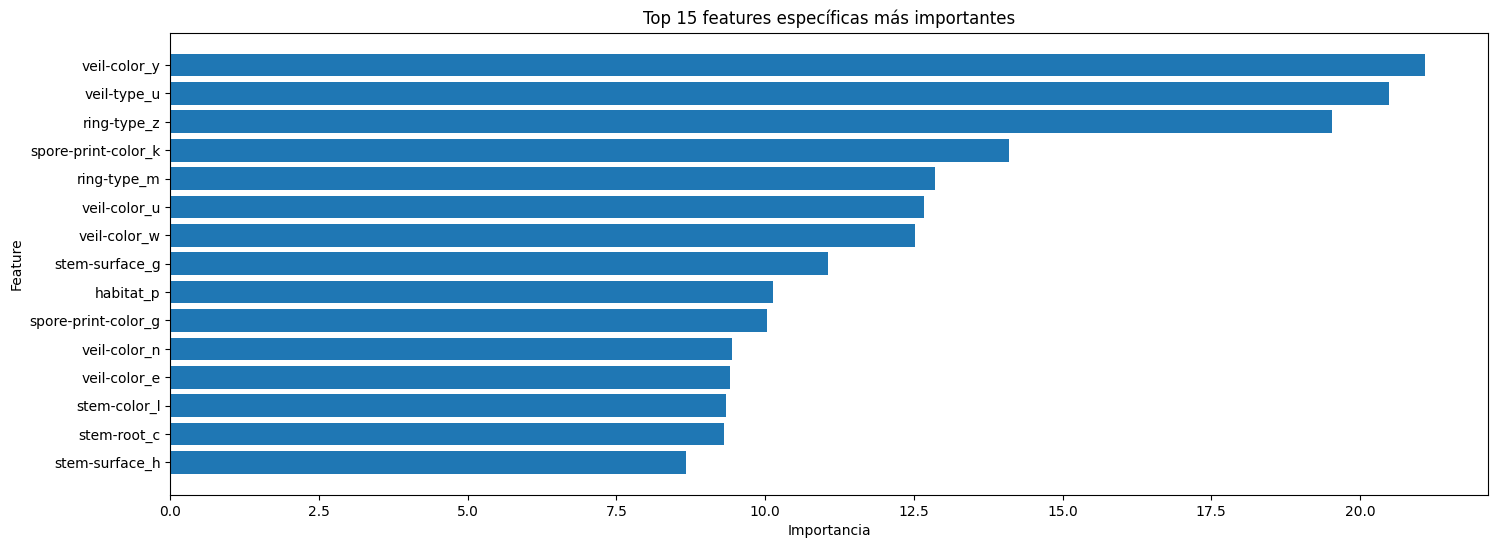

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots( figsize=(17,6) )

top_15 = df_features_por_importancia.iloc[ -15: ]

plt.barh(y=top_15.index, width=top_15["importancia_feature"])

plt.xlabel("Importancia")
plt.ylabel("Feature")
plt.title("Top 15 features específicas más importantes")

In [ ]:
df_features_por_importancia.index = df_features_por_importancia.index.map(lambda x: x.split("_")[0])
columnas_por_importancia = df_features_por_importancia.groupby(df_features_por_importancia.index).sum().sort_values(by="importancia_feature", ascending=True)

Text(0.5, 1.0, 'Features en general más influyentes para saber si un hongo es venenoso o comestible')

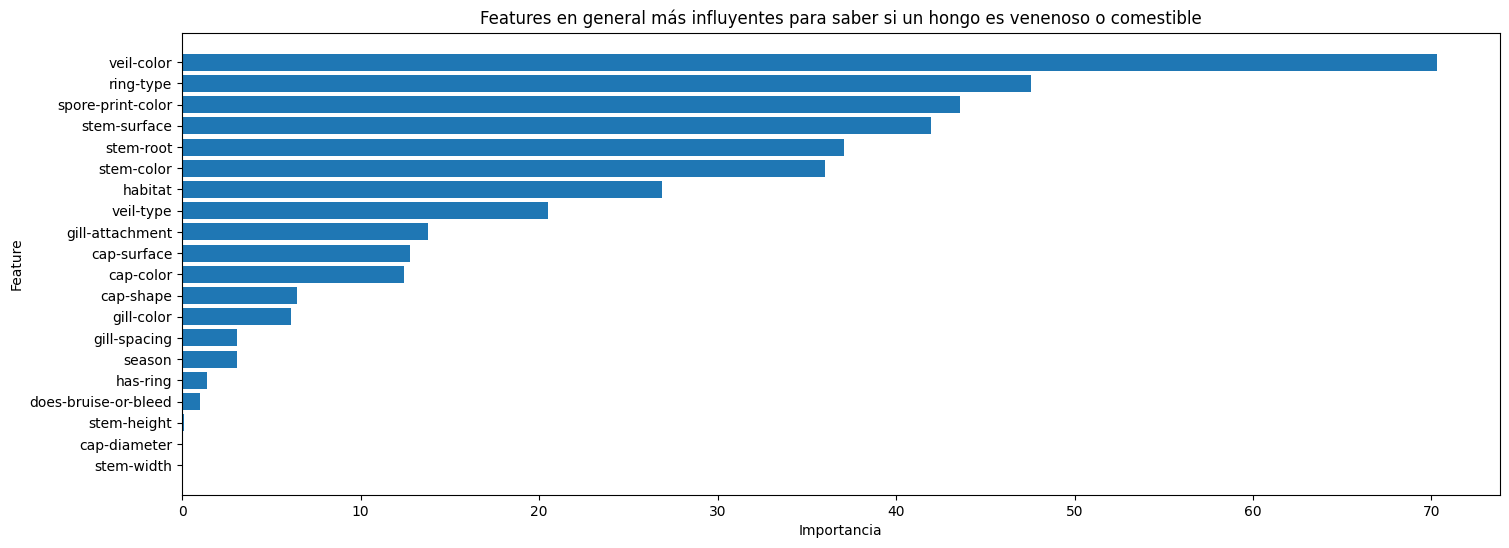

In [ ]:
fig, ax = plt.subplots( figsize=(17,6) )

plt.barh(y=columnas_por_importancia.index, width=columnas_por_importancia["importancia_feature"])

plt.xlabel("Importancia")
plt.ylabel("Feature")
plt.title("Features en general más influyentes para saber si un hongo es venenoso o comestible")